<div class="alert alert-block alert-success">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Final Project1</h3>
</div>

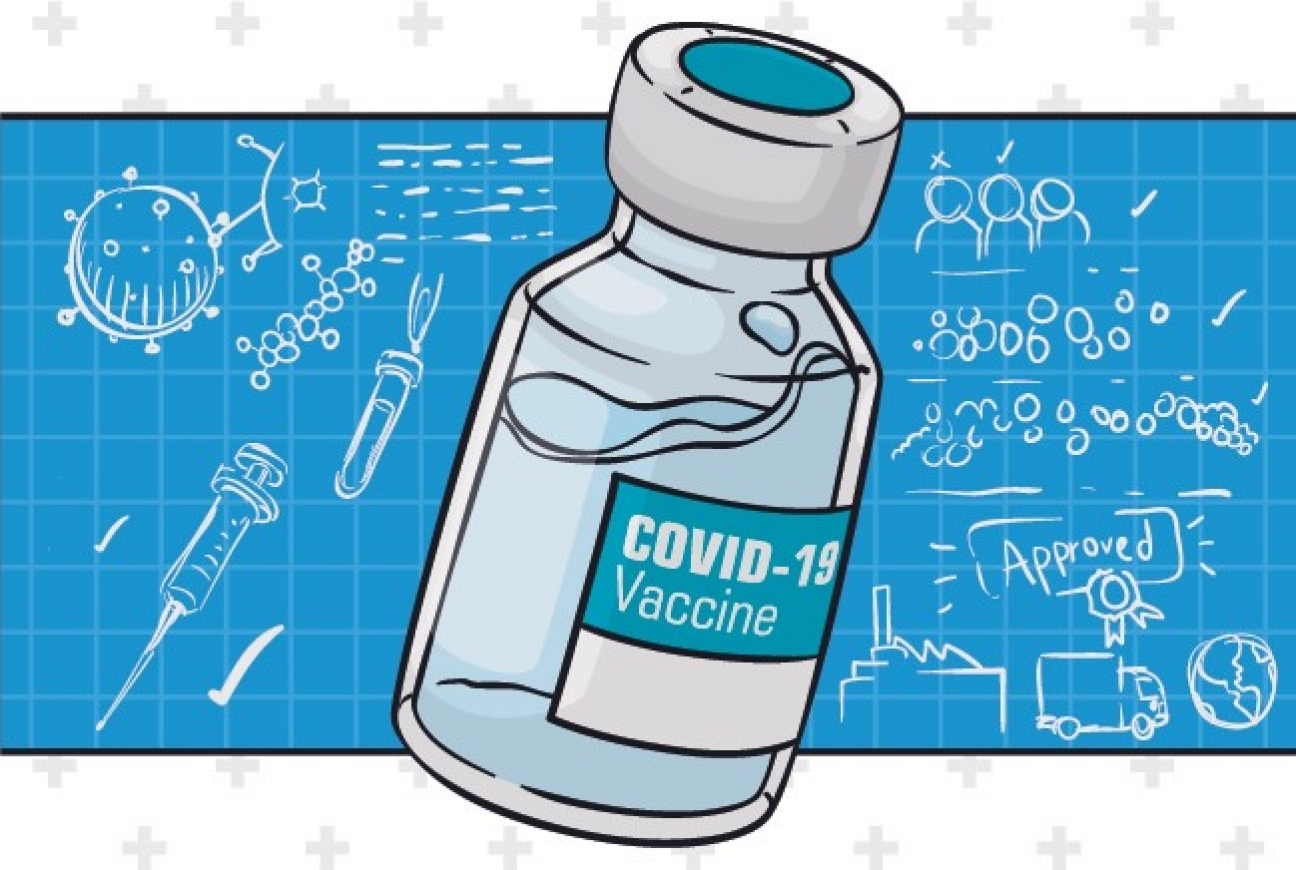

## Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Load and Prepare Data

In [ ]:
df = pd.read_csv('./country_vaccinations.csv')
df.head()

## EDA

In [ ]:
df.columns

In [ ]:
df['country'].unique()

In [ ]:
df.drop(['iso_code', 'source_name', 'source_website'],axis=1, inplace=True)

df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df.dropna(subset='total_vaccinations', inplace=True)
df.dropna(subset='people_vaccinated', inplace=True)
df.dropna(subset='people_fully_vaccinated', inplace=True)

df.isna().sum()

## Data Preprocessing

In [ ]:
df.fillna(df.drop(['country', 'date', 'vaccines'], axis=1).mean(), inplace=True)

df.isna().sum()

## Strorytelling - Visualization

In [ ]:
iran_data = df[df['country'] == 'Iran'].sort_values('date')
iran_data

In [ ]:
sns.barplot(iran_data, x='date' ,y='total_vaccinations_per_hundred')

In [ ]:
country_sorted = (
    df.sort_values('date')
    .groupby('country', as_index=False)
    .last()[['country', 'total_vaccinations_per_hundred']]
    .sort_values('total_vaccinations_per_hundred', ascending=False)
)

country_sorted

In [ ]:
countries = ['Iran', 'Qatar', 'France', 'Finland', 'Turkey', 'Iraq', 'India', 'Syria', 'Thailand', 'Australia', 'Spain', 'Russia', 'China', 'United Kingdom', 'United States']

ax = sns.barplot(
    data=country_sorted.query('country in @countries').sort_values('total_vaccinations_per_hundred', ascending=False),
    y='country',
    x='total_vaccinations_per_hundred'
)

ax.bar_label(ax.containers[0], fmt='%.1f');

## Prepare Data for Machine learning

In [ ]:
features = [
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'daily_vaccinations_per_million'
]

In [ ]:
df_country = (
    df.sort_values('date')
    .groupby('country')[features]
    .last()
    .reset_index()
)

df_view = df_country['country'].copy()

X = df_country[features]
X

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

## Train your model

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
clusters

In [ ]:
df_country['cluster'] = clusters

In [ ]:
df_country[['country', 'cluster']].sort_values('cluster')

## Interpret the model

In [ ]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_country['pca_1'] = X_pca[:,0]
df_country['pca_2'] = X_pca[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_country,
    x='pca_1',
    y='pca_2',
    hue='cluster',
    palette='tab10',
    s=80,
    alpha=0.8
)
plt.title('KMeans Clusters (PCA)')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_scaled)
df_country['tsne_1'] = X_tsne[:,0]
df_country['tsne_2'] = X_tsne[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_country,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='tab10',
    s=80,
    alpha=0.8
)
plt.title('KMeans Clusters (t-SNE)')
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

x = df_country['total_vaccinations_per_hundred']
y = df_country['people_vaccinated_per_hundred']
z = df_country['people_fully_vaccinated_per_hundred']
c = df_country['cluster']  

sc = ax.scatter(x, y, z, c=c, cmap='tab10', s=80, alpha=0.8)

ax.set_xlabel('Total Vaccinations per Hundred')
ax.set_ylabel('People Vaccinated per Hundred')
ax.set_zlabel('People Fully Vaccinated per Hundred')
ax.set_title('3D Scatter of KMeans Clusters')

plt.colorbar(sc, label='Cluster')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_pca3 = pca.fit_transform(X_scaled)

df_country['pca_1'] = X_pca3[:,0]
df_country['pca_2'] = X_pca3[:,1]
df_country['pca_3'] = X_pca3[:,2]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df_country['pca_1'],
    df_country['pca_2'],
    df_country['pca_3'],
    c=df_country['cluster'],
    cmap='tab10',
    s=80,
    alpha=0.8
)
ax.set_title('3D PCA of KMeans Clusters')
plt.colorbar(sc, label='Cluster')
plt.show()


In [ ]:
import plotly.express as px

# Convert cluster to string for categorical coloring
df_country['cluster_label'] = df_country['cluster'].astype(str)

# Create 3D interactive scatter plot
fig = px.scatter_3d(
    df_country,
    x='total_vaccinations_per_hundred',       # X-axis feature
    y='people_vaccinated_per_hundred',        # Y-axis feature
    z='people_fully_vaccinated_per_hundred',  # Z-axis feature
    color='cluster_label',                     # Color by cluster
    hover_name='country',                      # Show country name on hover
    size_max=20,                               # Maximum point size
    opacity=0.8,
    title='Interactive 3D Scatter of KMeans Clusters'
)

# Increase default zoom by moving camera closer
fig.update_layout(
    scene_camera=dict(
        eye=dict(x=0, y=0.5, z=0.3)  # smaller values = closer zoom
    )
)

# Display the interactive figure
fig.show()


## Save your final model